**EXPLICACION DEL ARCHIVO**

En este archivo principalmente se exploro la utilización de distintos filtros para el preprocesado de las imagenes. Se exploraron distintas propiedades para construir máscaras que permitan la separación de la fruta del fondo. Se propuso la utilización de algoritmos genéticos para encontrar el mejor contorno que spare a la fruta del fondo cuando el fondo no está normalizado.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pylab as plt
from sklearn.cluster import KMeans

In [2]:
image_path     = '../../../dataset/images'
training_path  = os.path.join(image_path, 'training')
original_path  = os.path.join(training_path, 'original')
processed_path = os.path.join(training_path, 'processed')

In [3]:
original  = [os.path.join(original_path, image) for image in os.listdir(original_path)]
processed = [os.path.join(processed_path, image) for image in os.listdir(processed_path)]

**GET MIN SIZE**

In [ ]:
minsize  = None
minshape = None
for image in original:
    data = cv2.imread(image)
    shape = data.shape
    size = shape[0]*shape[1]

    if (minsize == None)or(size < minsize):
        minshape = shape
        minsize  = size

**RESIZING**

El resizing distorsiona un poco mucho algunas de las imágenes, sobre todo la forma y pienso que si está es una característica que se va a utilizar para el clustering entonces no conviene el resizing además de que no me parece que sea necesario llevarlo a cabo

In [14]:
for image in original:
    data = cv2.imread(image)
    resized = cv2.resize(data, minshape[:2], interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join(processed_path, os.path.basename(image)), resized)

**DETECCIÓN DE BORDES**

In [ ]:
# Cargar la imagen
image = cv2.imread(processed[0], cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(figsize = (5, 5))
ax.imshow(image, cmap='gray')
plt.show()

**APLICACIÓN DE FILTROS DE PREPROCESADO**
- El filtro de denoising anda bastante joya
- El filtro de corrección de sombras funciona bien en el caso de las imágenes con fondo blanco que tiene luminosidad no uniforme
- De lo que logramos aca solamente puedo rescatar, para todos los fondos el filtro de denoising. En cambio para el caso de los de fondo blanco también rescato la función de corrección de sombras

In [ ]:
from cv2_rolling_ball import subtract_background_rolling_ball
from skimage.restoration import estimate_sigma
import copy
for file in processed:
    # Leer la imagen de la fruta (reemplaza 'fruta.jpg' con el nombre de tu archivo)
    fruta_image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(fruta_image, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(fruta_image, cv2.COLOR_BGR2LAB)
    l,_,_ = cv2.split(lab)

    sigma_est  = estimate_sigma(gray_image)
    # Aplicar filtro Non-Local Means para reducir el ruido
    denoised_image = cv2.fastNlMeansDenoising(fruta_image, None, h=1.8*sigma_est, templateWindowSize=12, searchWindowSize=30)
    denoised_copy  = copy.copy(denoised_image) 

    # Aplicar filtro para la atenuación de las sombras (rolling ball)
    radius =  200

    # Aplicar Otsu's thresholding
    ret, otsu_mask = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Determinar si el fondo es blanco o no
    background_is_white = cv2.mean(l, mask=otsu_mask)[0] > 185

    final_img, background = subtract_background_rolling_ball(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY), radius, light_background=background_is_white,
                                                            use_paraboloid=False, do_presmooth=True)
    #final_img = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)
    # Opcionalmente, realizar CLAHE para equalizar el histograma para una mejor segmentación
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
    clahe_img = clahe.apply(final_img)

    # Mostrar las imágenes originales y procesadas
    plt.figure(figsize=(10,5))
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(fruta_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(denoised_copy, cv2.COLOR_BGR2RGB))
    plt.title('Denoised Image')
    plt.subplot(1, 5, 3)
    plt.imshow(background, cmap='gray')
    plt.title('backgroud')
    plt.subplot(1, 5, 4)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_GRAY2RGB))
    plt.title('final')
    plt.subplot(1, 5, 5)
    plt.imshow(cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB))
    plt.title('CLAHE')
    plt.show()

**DETECCIÓN DE BORDES SIN UMBRALIZACIÓN CON SOBEL**

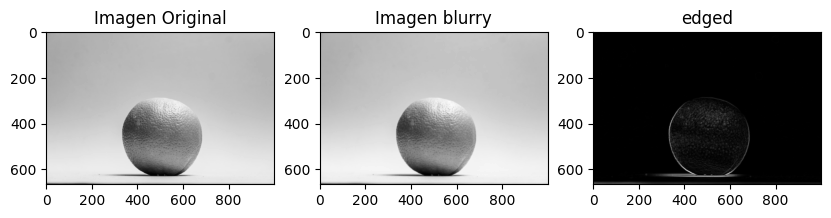

In [4]:
for i, file in enumerate(original):
    if i > 0:
        break
    # Aplicar el Filtro Gaussiano

    image   = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    sobelx  = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalizar la magnitud a valores entre 0 y 255
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagen Original')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred_image, cmap='gray')
    plt.title('Imagen blurry')

    plt.subplot(1, 3, 3)
    plt.imshow(magnitude, cmap='gray')
    plt.title('edged')

**MASCARA DE COLOR**

In [ ]:
for file in processed:
    # Cargar la imagen
    image = cv2.imread(file)

    #blurred_image = cv2.GaussianBlur(image, (5, 5), 3)
    # Convertir la imagen a espacio de color HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #hsv_blurry = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2HSV)
    #blurred_image  = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    blurred_image = cv2.bilateralFilter(image, d=20, sigmaColor=80, sigmaSpace=100)
    hsv_blurry = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2HSV)
    # Definir rangos para rojo, naranja, verde y amarillo en espacio HSV
    '''lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    lower_orange = np.array([11, 100, 100])
    upper_orange = np.array([25, 255, 255])

    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])

    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])'''

    '''lower_red = np.array([0, 50, 100])
    upper_red = np.array([15, 255, 255])

    lower_orange = np.array([11, 100, 100])
    upper_orange = np.array([25, 255, 255])

    lower_green = np.array([30, 50, 50])  # Ajusta estos valores según tus necesidades
    upper_green = np.array([90, 255, 255])  # Ajusta estos valores según tus necesidades

    lower_yellow = np.array([20, 50, 50])
    upper_yellow = np.array([30, 255, 255])'''

    '''lower_red_1 = np.array([0, 128, 50])
    upper_red_1 = np.array([10, 255, 255])

    lower_red_2 = np.array([172, 128, 50])
    upper_red_2 = np.array([179, 255, 255])

    lower_orange = np.array([8, 128, 100])
    upper_orange = np.array([22, 255, 255])

    lower_green = np.array([28, 50, 50])  # Ajusta estos valores según tus necesidades
    upper_green = np.array([95, 255, 255])  # Ajusta estos valores según tus necesidades

    lower_yellow = np.array([18, 100, 100])
    upper_yellow = np.array([33, 255, 255])'''
    '''lower_green = np.array([28, 40, 40])
    upper_green = np.array([100, 255, 255])

    lower_red_1 = np.array([0, 50, 70])
    upper_red_1 = np.array([6, 255, 255])

    lower_red_2 = np.array([170, 50, 70])
    upper_red_2 = np.array([179, 255, 255])

    lower_yellow = np.array([18, 50, 80])
    upper_yellow = np.array([33, 255, 255])

    lower_orange = np.array([8, 120, 120])
    upper_orange = np.array([20, 255, 255])'''
    '''lower_green = np.array([28, 40, 40])
    upper_green = np.array([100, 255, 255])

    lower_red_1 = np.array([0, 50, 70])
    upper_red_1 = np.array([6, 255, 255])

    lower_red_2 = np.array([170, 50, 70])
    upper_red_2 = np.array([179, 255, 255])

    lower_yellow = np.array([18, 50, 80])
    upper_yellow = np.array([33, 255, 255])

    lower_orange = np.array([7, 120, 90])
    upper_orange = np.array([20, 255, 255])'''
    lower_green = np.array([28, 40, 40])
    upper_green = np.array([100, 255, 255])

    lower_red_1 = np.array([0, 120, 100])
    upper_red_1 = np.array([5, 255, 255])

    lower_red_2 = np.array([170, 120, 100])
    upper_red_2 = np.array([179, 255, 255])

    lower_yellow = np.array([18, 50, 80])
    upper_yellow = np.array([33, 255, 255])

    lower_orange = np.array([5, 120, 90])
    upper_orange = np.array([20, 255, 255])


    # Crear máscaras para cada color
    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    b_mask_red    = cv2.inRange(hsv_blurry, lower_red_1, upper_red_1) | cv2.inRange(hsv_blurry, lower_red_2, upper_red_2)
    b_mask_orange = cv2.inRange(hsv_blurry, lower_orange, upper_orange)
    b_mask_green  = cv2.inRange(hsv_blurry, lower_green, upper_green)
    b_mask_yellow = cv2.inRange(hsv_blurry, lower_yellow, upper_yellow)
    

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow
    b_combined_mask = b_mask_red | b_mask_orange | b_mask_green | b_mask_yellow

    # Aplicar la máscara a la imagen original
    result_image = cv2.bitwise_and(image, image, mask=combined_mask)
    result_blurry = cv2.bitwise_and(image, image, mask=b_combined_mask)

    # Visualizar la imagen original y el resultado con la máscara aplicada
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen blurry')

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(result_blurry, cv2.COLOR_BGR2RGB))
    plt.title('masked blurry')

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title('masked original')


**PRUEBA DE KMEANS CON LOS RGB DIRECTAMENTE**

In [ ]:
# Cargar la imagen
image = cv2.imread(processed[1])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB

# Reshape de la imagen para que sea una lista de píxeles RGB
pixels = image.reshape((-1, 3))

# Aplicar K-means con 2 clusters (frutas y fondo)
kmeans = KMeans(n_clusters=2)
kmeans.fit(pixels)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Crear una máscara basada en las etiquetas
mask = labels.reshape(image.shape[0], image.shape[1])

# Mostrar la imagen original y la máscara
cv2.imshow('Original Image', image)
cv2.imshow('K-means Mask', mask.astype(np.uint8) * 255)
cv2.waitKey(0)
cv2.destroyAllWindows()


**PRUEBA DEL KMEANS CON LA TEXTURA**

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# Cargar la imagen
image = cv2.imread(processed[3])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB

# Convertir la imagen a escala de grises
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Configurar los parámetros del filtro de Gabor
ksize = 51  # Tamaño del kernel
sigma = 2.0  # Desviación estándar del filtro de Gabor
theta = np.pi  # Orientación del filtro de Gabor
lambda_ = 1   # Longitud de onda del filtro de Gabor
gamma = 1  # Factor de aspecto del filtro de Gabor

# Obtener el kernel de Gabor
gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambda_, gamma)

# Aplicar el filtro de Gabor para obtener características de textura
filtered_image = cv2.filter2D(gray_image, cv2.CV_64F, gabor_kernel)

# Normalizar las características para ser utilizadas en K-means
normalized_features = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min()) * 255
normalized_features = normalized_features.astype(np.uint8)

# Reshape de las características para ser utilizadas en K-means
reshaped_features = normalized_features.reshape((-1, 1))

combined_features = np.column_stack((image.reshape((-1, 3)), reshaped_features))
#combined_features = reshaped_features

# Aplicar K-means con 2 clusters (frutas y fondo)
kmeans = KMeans(n_clusters=2)
kmeans.fit(combined_features)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Crear una máscara basada en las etiquetas
mask = labels.reshape(image.shape[0], image.shape[1])

# Mostrar la imagen original y la máscara
cv2.imshow('Original Image', image)
cv2.imshow('K-means + Gabor Mask', mask.astype(np.uint8) * 255)
cv2.waitKey(0)
cv2.destroyAllWindows()


**OTRA PRUEBA DE KMEANS**

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# Cargar la imagen
image = cv2.imread(processed[1])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB

# Convertir la imagen a escala de grises y HSV
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Configurar los parámetros del filtro de Gabor
ksize = 31  # Tamaño del kernel
sigma = 3  # Desviación estándar del filtro de Gabor
theta = np.pi  # Orientación del filtro de Gabor
lambda_ = 2.0  # Longitud de onda del filtro de Gabor
gamma = 1  # Factor de aspecto del filtro de Gabor

# Obtener el kernel de Gabor
gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambda_, gamma)

# Aplicar el filtro de Gabor para obtener características de textura
filtered_image = cv2.filter2D(gray_image, cv2.CV_64F, gabor_kernel)

# Normalizar las características de textura para ser utilizadas en K-means
normalized_texture = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())

# Obtener los valores RGB normalizados para ser utilizados en K-means
normalized_rgb = image.reshape((-1, 3)).astype(np.float32) / 255.0

# Obtener los valores HSV normalizados para ser utilizados en K-means
normalized_hsv = hsv_image.reshape((-1, 3)).astype(np.float32) / np.array([180.0, 255.0, 255.0])

# Combinar características de textura, RGB y HSV
combined_features = np.column_stack((normalized_texture.reshape((-1, 1)), normalized_rgb))
#combined_features = np.column_stack((normalized_rgb))
#combined_features = normalized_texture.reshape((-1, 1))

# Aplicar K-means con 2 clusters (frutas y fondo)
kmeans = KMeans(n_clusters=2)
kmeans.fit(combined_features)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Crear una máscara basada en las etiquetas
mask = labels.reshape(image.shape[0], image.shape[1])

# Mostrar la imagen original y la máscara
cv2.imshow('Original Image', image)
cv2.imshow('K-means Mask', mask.astype(np.uint8) * 255)
cv2.waitKey(0)
cv2.destroyAllWindows()


**PRUEBA DE LA ENTROPIA**

No funciona bien

In [ ]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
for file in processed:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img2 = img.reshape(-1)
    entropy_img = entropy(img, disk(3))
    scaled_entropy = entropy_img / entropy_img.max()

    entropy1 = entropy_img.reshape(-1)

    cv2.imshow('original', img)
    cv2.imshow('entropy', entropy_img)
    cv2.waitKey()
    cv2.destroyAllWindows()


**DETERMINACIÓN DEL TIPO DE FONDO**

In [ ]:
for file in processed:
    fruta_image = cv2.imread(file)
    lab = cv2.cvtColor(fruta_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Aplicar Otsu's thresholding
    ret, otsu_mask = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Determinar si el fondo es blanco o no
    background_is_white = cv2.mean(l, mask=otsu_mask)[0] > 185

    plt.figure(figsize = (2,2))
    plt.subplot(1, 2,1)
    plt.imshow(cv2.cvtColor(fruta_image, cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(otsu_mask, cmap='gray')
    plt.title(os.path.basename(file))
    plt.show()

    if background_is_white:
        print("blanco")
    else:
        print("no blanco")


**TRATAR DE IDENTIFICAR COLOR DIBUJANDO UN RECTANGULO**
- Bastante bien. Probamos hacerle un suavizado previo, osea, eliminación de ruido

In [ ]:
from skimage.restoration import estimate_sigma
for file in processed:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)
    # Aplicar filtro Non-Local Means para reducir el ruido
    denoised_image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color naranja en HSV
    lower_green = np.array([28, 40, 40])
    upper_green = np.array([100, 255, 255])

    lower_red_1 = np.array([0, 120, 100])
    upper_red_1 = np.array([5, 255, 255])

    lower_red_2 = np.array([170, 120, 100])
    upper_red_2 = np.array([179, 255, 255])

    lower_yellow = np.array([18, 50, 80])
    upper_yellow = np.array([33, 255, 255])

    lower_orange = np.array([5, 120, 90])
    upper_orange = np.array([20, 255, 255])

    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    # Encontrar contornos en la máscara
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area_max = None
    # Iterar sobre los contornos y dibujar rectángulos alrededor de los objetos naranjas
    for contour in contours:
    # Calcular el centroide del contorno
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            # Dibujar un rectángulo alrededor del objeto
            x, y, w, h = cv2.boundingRect(contour)

            # Calcular las nuevas coordenadas del rectángulo con 5 píxeles agregados en cada lado
            x = max(0, x - 5)
            y = max(0, y - 5)
            w = min(image.shape[1] - x, w + 5)
            h = min(image.shape[0] - y, h + 5)

            # Dibujar el rectángulo ajustado
            cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 2)

            area = w * h
            if (area_max is None) or (area > area_max):
                rectange = (x, y, w, h)
                area_max = area


    cv2.rectangle(denoised_image, rectange[0:2], (rectange[0] + rectange[2], rectange[1] + rectange[3]), (0, 255, 0), 2)
    # Mostrar la imagen con los resultados
    cv2.imshow('Detected Objects', denoised_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


**PRUEBA DE DETECCIÓN DE CONTORNOS LUEGO DE FILTRO DE RUIDO**

In [ ]:
from skimage.restoration import estimate_sigma
for file in processed:
    
    image   = cv2.imread(file)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)
    denoised = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    denoised_gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    
    '''sobelx  = cv2.Sobel(denoised_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(denoised_gray, cv2.CV_64F, 0, 1, ksize=9)'''
    sobelx  = cv2.Sobel(denoised[:,:,1], cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(denoised[:,:,1], cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalizar la magnitud a valores entre 0 y 255
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    plt.figure(figsize=(5, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
    plt.title('Imagen denoised')

    plt.subplot(1, 3, 3)
    plt.imshow(magnitude, cmap = 'gray')
    plt.title('edged')

**PROBAMOS APLICAR EL FILTRO DE SOBEL RESPECTO DE LOS VALORES HSV**
- Funciona dentro de todo bien con S. Permite eliminar algunos bordes que no nos interesan aunque también aparecen bastantes texturas dentro y fuera de la propia fruta
- Con el H no se diferencia my bien la fruta del fondo por el contorno cuando se aplica sobel. En algunos casos sí se detecta el contorno cuando el fondo no es blanco y es algun fondo medio raro. Con lo cual en esos casos podría llegar a servir
- Con el V se diferencian bastate también

In [ ]:
from skimage.restoration import estimate_sigma
for file in processed:
    
    image   = cv2.imread(file)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)
    denoised = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    '''sobelx  = cv2.Sobel(denoised_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(denoised_gray, cv2.CV_64F, 0, 1, ksize=9)'''
    sobelx  = cv2.Sobel(hsv_image[:,:,2], cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(hsv_image[:,:,2], cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalizar la magnitud a valores entre 0 y 255
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    plt.figure(figsize=(5, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
    plt.title('Imagen denoised')

    plt.subplot(1, 3, 3)
    plt.imshow(magnitude, cmap = 'gray')
    plt.title('edged')

**KMeans con RGB, LBA, HSV y escala de gris**
- Con todas las componentes y el Kmeans anda medio bien pero aun no separa la fruta del fondo.
- Con PCA a una componente anda bien igual pero no separa de forma deifinitiva la fruta del fondo

In [ ]:
# Leer la imagen
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
for k, file in enumerate(processed):
    image = cv2.imread(file)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sigma_est  = estimate_sigma(gray_image)
    image= cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)

    # Cambiar el espacio de color de BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Obtener las dimensiones de la imagen
    height, width, _ = image.shape

    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    


    # Aplicar K-Means al vector de datos
    pca           = PCA(n_components = 4)
    scaler        = StandardScaler()
    scaled        = scaler.fit_transform(data_vector)
    reduced       = pca.fit_transform(scaled)
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(reduced)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask = labels.reshape(height, width)

    # Mostrar la imagen original y la máscara resultante
    cv2.imshow(os.path.basename(file), image_rgb)
    cv2.imshow(f"{i}", mask.astype(np.uint8) * 255)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


**PRUEBA DETERMINACIÓN DE CONTORNOS QUEDANSOSE CON EL MAS EXTENSO**
- No funciona de forma definitiva al no encontrarse todos los contornos cerrados
- Y sin otsu también anda bastante mal

In [ ]:
# Leer la imagen
from skimage.restoration import estimate_sigma
for i, file in enumerate(processed):
    bgr_image = cv2.imread(file)
    image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    sigma_est  = estimate_sigma(image)
    denoised = cv2.fastNlMeansDenoising(bgr_image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    image = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

    # Aplicar el filtro de Sobel
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, binary_image = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cv2.imshow(f"{i}", binary_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # Encontrar contornos en la imagen binarizada
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontrar el contorno más grande
    max_contour = max(contours, key=cv2.contourArea)

    # Dibujar un rectángulo alrededor del contorno más grande
    x, y, w, h = cv2.boundingRect(max_contour)
    result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Mostrar la imagen original y el resultado
    cv2.imshow(os.path.basename(file), image)
    cv2.imshow(f"{i}", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


**VAMOS A PROBAR VARIAS MASCARAS SOBRE LAS MISMAS FOTOS Y COMPARARLAS**

Obtenemos primero las fotos mas complicadas

In [ ]:
complicated = []
for file in processed:
    img = cv2.imread(file)
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    c = input('agregar?')
    if c == 'y':
        complicated.append(file)

*Verificación de las fotos complicadas*
- Verificado que son las fotos mas complicadas

In [ ]:
for file in complicated:
    img = cv2.imread(file)
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

*Máscaras que tenemos que comparar*
- Mascara de color
- Kmeans con varias propiedades
- Mascara con contornos de filtros de sobel
- Mascara filtros de sobel a l, b, a y hsv
- Máscara por umbral

Es posible que directamente con el filtro de color y el kmeans sea suficiente para obtener la fruta del fondo agregando un poco mas de inteligencia por el hecho de que el kemans puede tirar a la fruta en blanco o en negro en distintas ejecuciones del programa

Es lo mismo la utilización de kmeans en cada uno de los canales h s v l b a que utilizar la umbralización definida por otsu

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])


for file in complicated:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    '''mask_kmeans = cv2.normalize(mask_kmeans, None, 0, 255, cv2.NORM_MINMAX)
    mask_kmeans = np.uint8(mask_kmeans)

    kmeans_c, _ = cv2.findContours(mask_kmeans, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_c, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gray_c, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_kmeans = np.copy(mask_kmeans)
    contour_color = np.copy(combined_mask)
    contour_gray = np.copy(mask_gray)

    contour_kmeans = cv2.cvtColor(contour_kmeans, cv2.COLOR_GRAY2RGB)
    contour_color = cv2.cvtColor(contour_color, cv2.COLOR_GRAY2RGB)
    contour_gray = cv2.cvtColor(contour_gray, cv2.COLOR_GRAY2RGB)

    # Dibujar los contornos en la imagen de contornos
    cv2.drawContours(contour_color, color_c, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(contour_gray, gray_c, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(contour_kmeans, kmeans_c, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno'''


    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans.astype(np.uint8) * 255, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

    kmeans_h = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans_h.fit(h.reshape((-1,1)))
    labels = kmeans_h.labels_
    mask_kmns_h = labels.reshape(h.shape)

    kmeans_s = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans_s.fit(s.reshape((-1,1)))
    labels = kmeans_s.labels_
    mask_kmns_s = labels.reshape(s.shape)

    kmeans_v = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans_v.fit(v.reshape((-1,1)))
    labels = kmeans_v.labels_
    mask_kmns_v = labels.reshape(v.shape)

    kmeans_l = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans_l.fit(l.reshape((-1,1)))
    labels = kmeans_l.labels_
    mask_kmns_l = labels.reshape(l.shape)

    kmeans_b = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans_b.fit(b.reshape((-1,1)))
    labels = kmeans_b.labels_
    mask_kmns_b = labels.reshape(b.shape)

    kmeans_a = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans_a.fit(a.reshape((-1,1)))
    labels = kmeans_a.labels_
    mask_kmns_a = labels.reshape(a.shape)

    plt.figure(figsize =(10,5))
    plt.subplot(1, 6, 1)
    plt.imshow(mask_kmns_h.astype(np.uint8) * 255, cmap='gray')
    plt.title('h')
    plt.subplot(1, 6, 2)
    plt.imshow(mask_kmns_s.astype(np.uint8) * 255, cmap='gray')
    plt.title('s')
    plt.subplot(1, 6, 3)
    plt.imshow(mask_kmns_v.astype(np.uint8) * 255, cmap='gray')
    plt.title('v')
    plt.subplot(1, 6, 4)
    plt.imshow(mask_kmns_l.astype(np.uint8) * 255, cmap='gray')
    plt.title('l')
    plt.subplot(1, 6, 5)
    plt.imshow(mask_kmns_b.astype(np.uint8) * 255, cmap='gray')
    plt.title('b')
    plt.subplot(1, 6, 6)
    plt.imshow(mask_kmns_a.astype(np.uint8) * 255, cmap='gray')
    plt.title('a')


*prueba de varias mascaras*

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])


for file in complicated:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans.astype(np.uint8) * 255, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

*prueba de las mascaras con contornos*

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])


for file in complicated:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)
    mask_kmeans = mask_kmeans.astype(np.uint8) * 255

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    #contornos
    color_cnt, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kmeans_cnt, _ = cv2.findContours(mask_kmeans, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gray_cnt, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h_cnt, _ = cv2.findContours(mask_h, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    s_cnt, _ = cv2.findContours(mask_s, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    v_cnt, _ = cv2.findContours(mask_v, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    l_cnt, _ = cv2.findContours(mask_l, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    b_cnt, _ = cv2.findContours(mask_b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    a_cnt, _ = cv2.findContours(mask_a, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Obtención de RGB
    colorWcnt = cv2.cvtColor(combined_mask, cv2.COLOR_GRAY2RGB)
    kmeansWcnt = cv2.cvtColor(mask_kmeans, cv2.COLOR_GRAY2RGB)
    grayWcnt = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
    hWcnt = cv2.cvtColor(mask_h, cv2.COLOR_GRAY2RGB)
    sWcnt = cv2.cvtColor(mask_s, cv2.COLOR_GRAY2RGB)
    vWcnt = cv2.cvtColor(mask_v, cv2.COLOR_GRAY2RGB)
    lWcnt = cv2.cvtColor(mask_l, cv2.COLOR_GRAY2RGB)
    bWcnt = cv2.cvtColor(mask_b, cv2.COLOR_GRAY2RGB)
    aWcnt = cv2.cvtColor(mask_a, cv2.COLOR_GRAY2RGB)

    #Dibujación de contornos
    cv2.drawContours(colorWcnt, color_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(kmeansWcnt, kmeans_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(grayWcnt, gray_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(hWcnt, h_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(sWcnt, s_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(vWcnt, v_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(lWcnt, l_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(bWcnt, b_cnt, -1, (0, 255, 0), 3)
    cv2.drawContours(aWcnt, a_cnt, -1, (0, 255, 0), 3)

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

    plt.figure(figsize =(10,5))
    plt.subplot(1, 9, 1)
    plt.imshow(colorWcnt)
    plt.title('color')
    plt.subplot(1, 9, 2)
    plt.imshow(kmeansWcnt)
    plt.title('kmeans')
    plt.subplot(1, 9, 3)
    plt.imshow(grayWcnt)
    plt.title('gray_umbral')
    plt.subplot(1, 9, 4)
    plt.imshow(hWcnt)
    plt.title('h')
    plt.subplot(1, 9, 5)
    plt.imshow(sWcnt)
    plt.title('s')
    plt.subplot(1, 9, 6)
    plt.imshow(vWcnt)
    plt.title('v')
    plt.subplot(1, 9, 7)
    plt.imshow(lWcnt)
    plt.title('l')
    plt.subplot(1, 9, 8)
    plt.imshow(bWcnt)
    plt.title('b')
    plt.subplot(1, 9, 9)
    plt.imshow(aWcnt)
    plt.title('a')
    plt.show()

**MASCARA DE COLORES Y DE COSAS PELADAS**

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])


for file in complicated:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans.astype(np.uint8) * 255, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

**PRUEBA DE LOS CONTORNOS CON SOBEL**

In [ ]:
from skimage.restoration import estimate_sigma
for file in complicated:
    image = cv2.imread(file)
    

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
    # Aplicar el filtro de Sobel
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, mask_sobel = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    '''sobelx  = cv2.Sobel(denoised_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(denoised_gray, cv2.CV_64F, 0, 1, ksize=9)'''
    sobelx  = cv2.Sobel(hsv_image[:,:,2], cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(hsv_image[:,:,2], cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude_v = np.sqrt(sobelx**2 + sobely**2)

    # Normalizar la magnitud a valores entre 0 y 255
    magnitude_v = cv2.normalize(magnitude_v, None, 0, 255, cv2.NORM_MINMAX)
    magnitude_v = np.uint8(magnitude_v)
    _, mask_sobel_v = cv2.threshold(magnitude_v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    sobelx  = cv2.Sobel(hsv_image[:,:,1], cv2.CV_64F, 1, 0, ksize=9)
    sobely  = cv2.Sobel(hsv_image[:,:,1], cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude_s = np.sqrt(sobelx**2 + sobely**2)

    # Normalizar la magnitud a valores entre 0 y 255
    magnitude_s = cv2.normalize(magnitude_s, None, 0, 255, cv2.NORM_MINMAX)
    magnitude_s = np.uint8(magnitude_s)
    _, mask_sobel_s = cv2.threshold(magnitude_s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    '''sobel_c, _ = cv2.findContours(mask_sobel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sobel_s_c, _ = cv2.findContours(mask_sobel_s, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sobel_v_c, _ = cv2.findContours(mask_sobel_v, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_sobel = np.copy(mask_sobel)
    contour_sobel_s = np.copy(mask_sobel_s)
    contour_sobel_v = np.copy(mask_sobel_v)
    
    contour_sobel = cv2.cvtColor(contour_sobel, cv2.COLOR_GRAY2RGB)
    contour_sobel_s = cv2.cvtColor(contour_sobel_s, cv2.COLOR_GRAY2RGB)
    contour_sobel_v = cv2.cvtColor(contour_sobel_v, cv2.COLOR_GRAY2RGB)

    cv2.drawContours(contour_sobel, sobel_c, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(contour_sobel_s, sobel_s_c, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(contour_sobel_v, sobel_v_c, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno'''
    sobel_x = cv2.Sobel(h, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(h, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, mask_h = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    sobel_x = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, mask_s = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    sobel_x = cv2.Sobel(v, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(v, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, mask_v = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    sobel_x = cv2.Sobel(l, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(l, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, mask_l = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    sobel_x = cv2.Sobel(b, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(b, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, mask_b = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    sobel_x = cv2.Sobel(a, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(a, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, mask_a = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 9, 1)
    plt.imshow(mask_sobel, cmap='gray')
    plt.title('sobel')
    plt.subplot(1, 9, 2)
    plt.imshow(mask_sobel_v, cmap='gray')
    plt.title('sobel_v')
    plt.subplot(1, 9, 3)
    plt.imshow(mask_sobel_s, cmap='gray')
    plt.title('sobel_s')
    plt.subplot(1, 9, 4)
    plt.imshow(mask_h, cmap='gray')
    plt.title('sobel')
    plt.subplot(1, 9, 5)
    plt.imshow(mask_s, cmap='gray')
    plt.title('sobel_v')
    plt.subplot(1, 9, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('sobel_s')
    plt.subplot(1, 9, 7)
    plt.imshow(mask_sobel, cmap='gray')
    plt.title('sobel')
    plt.subplot(1, 9, 8)
    plt.imshow(mask_sobel_v, cmap='gray')
    plt.title('sobel_v')
    plt.subplot(1, 9, 9)
    plt.imshow(mask_sobel_s, cmap='gray')
    plt.title('sobel_s')

'''    plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 1)
    plt.imshow(contour_sobel)
    plt.title('sobel')
    plt.subplot(1, 3, 2)
    plt.imshow(contour_sobel_v)
    plt.title('sobel_v')
    plt.subplot(1, 3, 3)
    plt.imshow(contour_sobel_s)
    plt.title('sobel_s')'''

**PRUEBA CONTORNOS DE SOBEL SOBRE MASCARAS**

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])


for file in complicated:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)
    mask_kmeans = mask_kmeans.astype(np.uint8) * 255

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    #contornos
    #color
    sobel_x = cv2.Sobel(combined_mask, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(combined_mask, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, colorWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #kmeans
    sobel_x = cv2.Sobel(mask_kmeans, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_kmeans, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, kmeansWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #gray
    sobel_x = cv2.Sobel(mask_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_gray, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, grayWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #h
    sobel_x = cv2.Sobel(mask_h, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_h, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, hWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #s
    sobel_x = cv2.Sobel(mask_s, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_s, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, sWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #v
    sobel_x = cv2.Sobel(mask_v, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_v, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, vWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #l
    sobel_x = cv2.Sobel(mask_l, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_l, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, lWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #b
    sobel_x = cv2.Sobel(mask_b, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_b, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, bWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #a
    sobel_x = cv2.Sobel(mask_a, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_a, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, aWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #whole
    whole = colorWcnt|kmeansWcnt|grayWcnt|hWcnt|sWcnt|vWcnt|lWcnt|bWcnt|aWcnt

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(colorWcnt, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 2)
    plt.imshow(kmeansWcnt, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 3)
    plt.imshow(grayWcnt, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 4)
    plt.imshow(hWcnt, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 5)
    plt.imshow(sWcnt, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 6)
    plt.imshow(vWcnt, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 7)
    plt.imshow(lWcnt, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 8)
    plt.imshow(bWcnt, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 9)
    plt.imshow(aWcnt, cmap='gray')
    plt.title('a')
    plt.imshow(whole, cmap='gray')
    plt.title('whole')
    plt.show()

**PRUEBA DE SUAVISADO SOBRE LAS MASCARAS**
- No presenta una gran mejoría

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])


for file in complicated:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)
    mask_kmeans = mask_kmeans.astype(np.uint8) * 255

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    # Suavizado de las mascaras
    combined_mask = cv2.fastNlMeansDenoising(combined_mask, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_kmeans = cv2.fastNlMeansDenoising(mask_kmeans, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_gray = cv2.fastNlMeansDenoising(mask_gray, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_h = cv2.fastNlMeansDenoising(mask_h, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_s = cv2.fastNlMeansDenoising(mask_s, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_v = cv2.fastNlMeansDenoising(mask_v, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_l = cv2.fastNlMeansDenoising(mask_l, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_b = cv2.fastNlMeansDenoising(mask_b, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    mask_a = cv2.fastNlMeansDenoising(mask_a, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)

    #contornos
    #color
    sobel_x = cv2.Sobel(combined_mask, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(combined_mask, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, colorWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #kmeans
    sobel_x = cv2.Sobel(mask_kmeans, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_kmeans, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, kmeansWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #gray
    sobel_x = cv2.Sobel(mask_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_gray, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, grayWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #h
    sobel_x = cv2.Sobel(mask_h, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_h, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, hWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #s
    sobel_x = cv2.Sobel(mask_s, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_s, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, sWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #v
    sobel_x = cv2.Sobel(mask_v, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_v, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, vWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #l
    sobel_x = cv2.Sobel(mask_l, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_l, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, lWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #b
    sobel_x = cv2.Sobel(mask_b, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_b, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, bWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #a
    sobel_x = cv2.Sobel(mask_a, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_a, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, aWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #whole
    whole = colorWcnt|kmeansWcnt|grayWcnt|hWcnt|sWcnt|vWcnt|lWcnt|bWcnt|aWcnt

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(colorWcnt, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 2)
    plt.imshow(kmeansWcnt, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 3)
    plt.imshow(grayWcnt, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 4)
    plt.imshow(hWcnt, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 5)
    plt.imshow(sWcnt, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 6)
    plt.imshow(vWcnt, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 7)
    plt.imshow(lWcnt, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 8)
    plt.imshow(bWcnt, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 9)
    plt.imshow(aWcnt, cmap='gray')
    plt.title('a')
    plt.imshow(whole, cmap='gray')
    plt.title('whole')
    plt.show()

**PRUEBA DE SUAVISADO SOBRE LOS CONTORNOS DE LAS MASCARAS OBTENIDAS CON SOBEL**
- Tampoco anda bien

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])


for file in complicated:
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)
    mask_kmeans = mask_kmeans.astype(np.uint8) * 255

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow


    #contornos
    #color
    sobel_x = cv2.Sobel(combined_mask, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(combined_mask, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, colorWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #kmeans
    sobel_x = cv2.Sobel(mask_kmeans, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_kmeans, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, kmeansWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #gray
    sobel_x = cv2.Sobel(mask_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_gray, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, grayWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #h
    sobel_x = cv2.Sobel(mask_h, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_h, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, hWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #s
    sobel_x = cv2.Sobel(mask_s, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_s, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, sWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #v
    sobel_x = cv2.Sobel(mask_v, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_v, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, vWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #l
    sobel_x = cv2.Sobel(mask_l, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_l, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, lWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #b
    sobel_x = cv2.Sobel(mask_b, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_b, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, bWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #a
    sobel_x = cv2.Sobel(mask_a, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_a, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, aWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #whole
    whole = colorWcnt|kmeansWcnt|grayWcnt|hWcnt|sWcnt|vWcnt|lWcnt|bWcnt|aWcnt

    # Suavizado de las mascaras
    colorWcnt = cv2.fastNlMeansDenoising(colorWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    grayWcnt = cv2.fastNlMeansDenoising(grayWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    hWcnt = cv2.fastNlMeansDenoising(hWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    sWcnt = cv2.fastNlMeansDenoising(sWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    vWcnt = cv2.fastNlMeansDenoising(vWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    lWcnt = cv2.fastNlMeansDenoising(lWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    bWcnt = cv2.fastNlMeansDenoising(bWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)
    aWcnt = cv2.fastNlMeansDenoising(aWcnt, None, h=10*sigma_est, templateWindowSize=20, searchWindowSize=50)

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(colorWcnt, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 2)
    plt.imshow(kmeansWcnt, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 3)
    plt.imshow(grayWcnt, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 4)
    plt.imshow(hWcnt, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 5)
    plt.imshow(sWcnt, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 6)
    plt.imshow(vWcnt, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 7)
    plt.imshow(lWcnt, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 8)
    plt.imshow(bWcnt, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 9)
    plt.imshow(aWcnt, cmap='gray')
    plt.title('a')
    plt.imshow(whole, cmap='gray')
    plt.title('whole')
    plt.show()

**PRUEBA DE DIBUJAR CONTORNOS SOBRE MASCARA OBTENIDA CON SOBEL**

c:\Users\Juan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


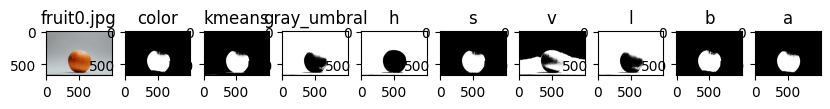

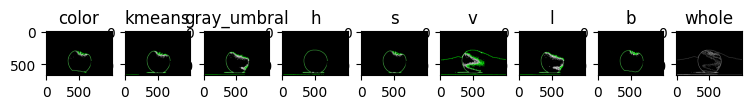

In [6]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])

grupo = [original[8]]
for k, file in enumerate(original):
    if k > 0:
        break
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)
    mask_kmeans = mask_kmeans.astype(np.uint8) * 255

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    #contornos
    #color
    sobel_x = cv2.Sobel(combined_mask, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(combined_mask, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, colorWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #kmeans
    sobel_x = cv2.Sobel(mask_kmeans, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_kmeans, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, kmeansWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #gray
    sobel_x = cv2.Sobel(mask_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_gray, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, grayWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #h
    sobel_x = cv2.Sobel(mask_h, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_h, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, hWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #s
    sobel_x = cv2.Sobel(mask_s, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_s, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, sWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #v
    sobel_x = cv2.Sobel(mask_v, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_v, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, vWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #l
    sobel_x = cv2.Sobel(mask_l, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_l, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, lWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #b
    sobel_x = cv2.Sobel(mask_b, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_b, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, bWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #a
    sobel_x = cv2.Sobel(mask_a, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_a, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, aWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #Encontrar contornos
    kmeans_cnt, _ = cv2.findContours(kmeansWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_cnt, _ = cv2.findContours(colorWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gray_cnt, _ = cv2.findContours(grayWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h_cnt, _ = cv2.findContours(hWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    s_cnt, _ = cv2.findContours(sWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    v_cnt, _ = cv2.findContours(vWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    l_cnt, _ = cv2.findContours(lWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    b_cnt, _ = cv2.findContours(bWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    a_cnt, _ = cv2.findContours(aWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #pasar a rgb
    colorWcnt  = cv2.cvtColor(colorWcnt, cv2.COLOR_GRAY2RGB)
    grayWcnt  = cv2.cvtColor(grayWcnt, cv2.COLOR_GRAY2RGB)
    kmeansWcnt  = cv2.cvtColor(kmeansWcnt, cv2.COLOR_GRAY2RGB)
    hWcnt  = cv2.cvtColor(hWcnt, cv2.COLOR_GRAY2RGB)
    sWcnt  = cv2.cvtColor(sWcnt, cv2.COLOR_GRAY2RGB)
    vWcnt  = cv2.cvtColor(vWcnt, cv2.COLOR_GRAY2RGB)
    lWcnt  = cv2.cvtColor(lWcnt, cv2.COLOR_GRAY2RGB)
    bWcnt  = cv2.cvtColor(bWcnt, cv2.COLOR_GRAY2RGB)
    aWcnt  = cv2.cvtColor(aWcnt, cv2.COLOR_GRAY2RGB)


    #Dibujar contornos
    cv2.drawContours(colorWcnt, color_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(kmeansWcnt, kmeans_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(grayWcnt, gray_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(hWcnt, h_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(sWcnt, s_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(vWcnt, v_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(lWcnt, l_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(bWcnt, b_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno
    cv2.drawContours(aWcnt, a_cnt, -1, (0, 255, 0), 2)  # El último argumento es el grosor del contorno

    whole = np.zeros((height, width), dtype=np.uint8)
    cv2.drawContours(whole, color_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, kmeans_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, gray_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, h_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, s_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, v_cnt, -1,255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, l_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, b_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, a_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno

    #plotting

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(file))
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(colorWcnt)
    plt.title('color')
    plt.subplot(1, 10, 2)
    plt.imshow(kmeansWcnt)
    plt.title('kmeans')
    plt.subplot(1, 10, 3)
    plt.imshow(grayWcnt)
    plt.title('gray_umbral')
    plt.subplot(1, 10, 4)
    plt.imshow(hWcnt)
    plt.title('h')
    plt.subplot(1, 10, 5)
    plt.imshow(sWcnt)
    plt.title('s')
    plt.subplot(1, 10, 6)
    plt.imshow(vWcnt)
    plt.title('v')
    plt.subplot(1, 10, 7)
    plt.imshow(lWcnt)
    plt.title('l')
    plt.subplot(1, 10, 8)
    plt.imshow(bWcnt)
    plt.title('b')
    plt.subplot(1, 10, 9)
    plt.imshow(aWcnt)
    plt.title('a')
    plt.imshow(whole, cmap='gray')
    plt.title('whole')
    plt.show()

**PRUEBA DE ALGORITMO GENÉTICO SOBRE UNA DE LAS IMÁGENES**

In [ ]:
from skimage.restoration import estimate_sigma
from sklearn.cluster import KMeans
import json

# Definir el rango de color naranja en HSV
lower_green = np.array([28, 40, 40])
upper_green = np.array([100, 255, 255])

lower_red_1 = np.array([0, 120, 100])
upper_red_1 = np.array([5, 255, 255])

lower_red_2 = np.array([170, 120, 100])
upper_red_2 = np.array([179, 255, 255])

lower_yellow = np.array([18, 50, 80])
upper_yellow = np.array([33, 255, 255])

lower_orange = np.array([5, 120, 90])
upper_orange = np.array([20, 255, 255])

complicated = [os.path.join(original_path, 'cruda.jpg')]

for k, file in enumerate(complicated):
    if k > 0:
        break
    # Leer la imagen
    image = cv2.imread(file)

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sigma_est  = estimate_sigma(gray_image)

    # Aplicar filtro Non-Local Means para reducir el ruido
    #image = cv2.fastNlMeansDenoising(image, None, h=2*sigma_est, templateWindowSize=15, searchWindowSize=30)
    height, width, _ = image.shape
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask_gray = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_gray = np.uint8(mask_gray)
 
    # Crear un vector para almacenar los datos de cada píxel
    data_vector = np.zeros((height * width, 10))  # 3 para RGB, 3 para HSV, 3 para LAB, 1 para escala de grises

    # Rellenar el vector con los valores de cada píxel
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]

            # RGB
            data_vector[i * width + j, :3] = pixel

            # HSV
            hsv_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2HSV)[0, 0]
            data_vector[i * width + j, 3:6] = hsv_pixel

            # LAB
            lab_pixel = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0, 0]
            data_vector[i * width + j, 6:9] = lab_pixel

            # Escala de grises
            data_vector[i * width + j, 9] = cv2.cvtColor(np.array([[pixel]], dtype=np.uint8), cv2.COLOR_RGB2GRAY)[0, 0]
    
    kmeans = KMeans(n_clusters=2)  # Puedes ajustar el número de clusters según tus necesidades
    kmeans.fit(data_vector)

    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_

    # Crear una máscara basada en las etiquetas
    mask_kmeans = labels.reshape(height, width)
    mask_kmeans = mask_kmeans.astype(np.uint8) * 255

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    l, a, b = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    _, mask_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, mask_a = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    mask_red    = cv2.inRange(hsv_image, lower_red_1, upper_red_1) | cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Unir las máscaras
    combined_mask = mask_red | mask_orange | mask_green | mask_yellow

    #contornos
    #color
    sobel_x = cv2.Sobel(combined_mask, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(combined_mask, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, colorWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #kmeans
    sobel_x = cv2.Sobel(mask_kmeans, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_kmeans, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, kmeansWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #gray
    sobel_x = cv2.Sobel(mask_gray, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_gray, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, grayWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #h
    sobel_x = cv2.Sobel(mask_h, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_h, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, hWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #s
    sobel_x = cv2.Sobel(mask_s, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_s, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, sWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #v
    sobel_x = cv2.Sobel(mask_v, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_v, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, vWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #l
    sobel_x = cv2.Sobel(mask_l, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_l, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, lWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #b
    sobel_x = cv2.Sobel(mask_b, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_b, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, bWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #a
    sobel_x = cv2.Sobel(mask_a, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(mask_a, cv2.CV_64F, 0, 1, ksize=9)

    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)

    # Binarizar la imagen con Otsu
    _, aWcnt = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #Encontrar contornos
    kmeans_cnt, _ = cv2.findContours(kmeansWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_cnt, _ = cv2.findContours(colorWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gray_cnt, _ = cv2.findContours(grayWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h_cnt, _ = cv2.findContours(hWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    s_cnt, _ = cv2.findContours(sWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    v_cnt, _ = cv2.findContours(vWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    l_cnt, _ = cv2.findContours(lWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    b_cnt, _ = cv2.findContours(bWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    a_cnt, _ = cv2.findContours(aWcnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Dibujar contornos
    #templates
    tcolor = np.zeros((height, width), dtype=np.uint8)
    tkmeans = np.zeros((height, width), dtype=np.uint8)
    tgray = np.zeros((height, width), dtype=np.uint8)
    th = np.zeros((height, width), dtype=np.uint8)
    ts = np.zeros((height, width), dtype=np.uint8)
    tv = np.zeros((height, width), dtype=np.uint8)
    tl = np.zeros((height, width), dtype=np.uint8)
    tb = np.zeros((height, width), dtype=np.uint8)
    ta = np.zeros((height, width), dtype=np.uint8)

    #dibujar
    cv2.drawContours(tcolor, color_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(tkmeans, kmeans_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(tgray, gray_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(th, h_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(ts, s_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(tv, v_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(tl, l_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(tb, b_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(ta, a_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno

    #superposición
    whole = np.zeros((height, width), dtype=np.uint8)
    cv2.drawContours(whole, color_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, kmeans_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, gray_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, h_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, s_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, v_cnt, -1,255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, l_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, b_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno
    cv2.drawContours(whole, a_cnt, -1, 255, 1)  # El último argumento es el grosor del contorno

    #plotting
    print('a')
    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('original')
    plt.subplot(1, 10, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 3)
    plt.imshow(mask_kmeans, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 4)
    plt.imshow(mask_gray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 5)
    plt.imshow(mask_h, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 6)
    plt.imshow(mask_s, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 7)
    plt.imshow(mask_v, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 8)
    plt.imshow(mask_l, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 9)
    plt.imshow(mask_b, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 10)
    plt.imshow(mask_a, cmap='gray')
    plt.title('a')
    plt.show()

    plt.figure(figsize =(10,5))
    plt.subplot(1, 10, 1)
    plt.imshow(tcolor, cmap='gray')
    plt.title('color')
    plt.subplot(1, 10, 2)
    plt.imshow(tkmeans, cmap='gray')
    plt.title('kmeans')
    plt.subplot(1, 10, 3)
    plt.imshow(tgray, cmap='gray')
    plt.title('gray_umbral')
    plt.subplot(1, 10, 4)
    plt.imshow(th, cmap='gray')
    plt.title('h')
    plt.subplot(1, 10, 5)
    plt.imshow(ts, cmap='gray')
    plt.title('s')
    plt.subplot(1, 10, 6)
    plt.imshow(tv, cmap='gray')
    plt.title('v')
    plt.subplot(1, 10, 7)
    plt.imshow(tl, cmap='gray')
    plt.title('l')
    plt.subplot(1, 10, 8)
    plt.imshow(tb, cmap='gray')
    plt.title('b')
    plt.subplot(1, 10, 9)
    plt.imshow(ta, cmap='gray')
    plt.title('a')
    plt.subplot(1, 10, 10)
    plt.imshow(whole, cmap='gray')
    plt.title('whole')
    plt.show()

In [ ]:
def get_extenssion(mask, contorno, num_cuadriculas_x, num_cuadriculas_y):
    h, w = mask.shape
    # Calcular el ancho y la altura de cada cuadrícula
    ancho_cuadricula = w // num_cuadriculas_x
    altura_cuadricula = h // num_cuadriculas_y

    # Inicializar el contador de cuadrículas atravesadas por el contorno
    cuadriculas_atravesadas = 0
    cuadriculas_contadas = set()

    # Verificar por cuántas cuadrículas pasa el contorno
    for punto in contorno[:, 0, :]:
        # Obtener las coordenadas (x, y) del punto
        x, y = punto

        # Determinar la cuadrícula a la que pertenece el punto
        cuadricula_x = x // ancho_cuadricula
        cuadricula_y = y // altura_cuadricula

        # Aumentar el contador si la cuadrícula no ha sido contada previamente
        if (cuadricula_x, cuadricula_y) not in cuadriculas_contadas:
            cuadriculas_atravesadas += 1
            cuadriculas_contadas.add((cuadricula_x, cuadricula_y))

    return cuadriculas_atravesadas

In [ ]:
def get_spykes(cntr, umbral = np.pi/12):
    angles = []
    for i, p in enumerate(cntr):
        if i >= (cntr.shape[0] - 2):
            break
        else:
            p2 = cntr[i + 1]
            p3 = cntr[i + 2]
            v1 = p2 - p
            v2 = p3 - p2
            v1 = v1.reshape(-1,)
            v2 = v2.reshape(-1,)

            cosine = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
            
            angle = np.arccos(np.clip(cosine, -1.0, 1.0))
            angles.append(angle)
    return sum(np.abs(np.diff(angles)) > umbral)

**PRBAMOS UNA NUEVA DEFINICIÓN DEL CRUCE MAS ORIENTADA A LOS CONTORNOS EN SÍ**

Esto anda bastante bien pero no da la respuesta mas óptima, la que esperamos todas las veces

In [ ]:
import random
#primero vamos a organizar las mascaras y contornos de las mascaras en listas:
masks       = [tcolor, tkmeans, tgray, th, ts, tv, tl, tb, ta]
masks_cntrs = [color_cnt, kmeans_cnt, gray_cnt, h_cnt, s_cnt, v_cnt, l_cnt, b_cnt, a_cnt]
heigth, width = masks[0].shape
max_pob = 500
pool = []

for p in range(max_pob):
    #Numero de contornos por mascara
    nro_cntrs  = [len(cntrs) for cntrs in masks_cntrs]

    if all(nro == 1 for nro in nro_cntrs):
        print(nro_cntrs)
        if all(cntrs[0].shape == masks_cntrs[0][0].shape for cntrs in masks_cntrs):
            if all((cntrs[0] == masks_cntrs[0][0]).all for cntrs in masks_cntrs):
                if not flag:
                    #p_mutacion = 1
                    flag = True
                else:
                    break
    #Contorno mas largo por mascara
    lrgst_cntrs = [max(cntrs, key=cv2.contourArea) for cntrs in masks_cntrs]

    #obtención del ratio promedio de los contornos por cada mascara
    cntrs_ratios = []
    for cntrs in masks_cntrs:
        ratios = []
        for cntr in cntrs:
            length = cv2.arcLength(cntr, closed=False)
            if length <= 0.0:
                ratios.append(length)
            else:
                ratios.append(cv2.contourArea(cntr)/length)
        cntrs_ratios.append(np.mean(np.array(ratios)))

    #Determinar si el contorno mas largo de cada mascara es cerrado o no
    lrgst_cntr_closed = [cv2.isContourConvex(cntr) for cntr in lrgst_cntrs]

    #Determinar la extensión de los contornos
    #Podemos determinar la calidad de la extensión de los contornos
    #Como la extensión promedio. Es decir, la suma de las extensiones de los contornos dividido el numero de ellos

    #Extensiones de los contornos mas largos
    lrgst_cntr_extenssion = [get_extenssion(mask, lrgst_cntrs[i], 4, 4)/16 for i, mask in enumerate(masks)]

    #Extensión promedio de los contornos en la mascara
    extenssions = [np.mean(np.array([get_extenssion(mask, contour, 4, 4)/16 for contour in masks_cntrs[i]])) for i, mask in enumerate(masks)]

    #Ahora obtener la función de idoneidad para cada mascara
    #Por el momento no vamos a utilizar las longitudes acumuladas sino mas bien los ratios promedios de los contornos de las mascaras
    total_cntrs = sum(nro_cntrs)
    total_ratio = sum(cntrs_ratios)     #Suma de los raitos de todos los contornos de todas las mascaras
    total_extenssion = sum(extenssions)
    total_lrgst_extenssion = sum(lrgst_cntr_extenssion)

    idoneidad = [(total_cntrs - nro)/((len(nro_cntrs) - 1)*total_cntrs) for nro in nro_cntrs]
    aux = [idoneidad[i] + ratio/total_ratio for i, ratio in enumerate(cntrs_ratios)] # Actualización de la idenoidad con ratio
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i] + extenssion/total_extenssion for i, extenssion in enumerate(extenssions)] # Actualización de la idenoidad con las extensiones
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i]*1.07 if closed else idoneidad[i] for i, closed in enumerate(lrgst_cntr_closed)] # Actualización de idoneidad con recomponsas por contornos largos cerrados
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i] + lrgst_ext/total_lrgst_extenssion for i, lrgst_ext in enumerate(lrgst_cntr_extenssion)] # Actualización de idoneidad
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i]*1.2 if nro == 1 else idoneidad[i] for i, nro in enumerate(nro_cntrs)]
    idoneidad = [value/sum(aux) for value in aux]

    #La idoneidad de los individuos aca está normalizada
    # El hecho de que la mascara este contenida en la superposición la vamos a utilizar como un mecanismo de pena de muerte
    p_mutacion = 0.001
    p_cruce    = 0.98

    print(f"({p}) - {idoneidad}")
    poblacion = []
    for _ in range(len(masks)//2 + 1):
        index = []
        #selección
        for _ in range(2):
            aguja = random.random()
            total = 0
            for i, value in enumerate(idoneidad):
                total += value
                if aguja < total:
                    break
            index.append(i)
        index = tuple(index)

        hijos = [] # Las listas de contornos de los hijos

        #cruce
        if random.random() < p_cruce:
            pases = []   # Las listas de contornos que se pasan
            for ind in index:
                hijo = list(masks_cntrs[ind])
                pase = []
                for _ in range(nro_cntrs[ind]//2):
                    k = random.choice(list(range(len(hijo))))
                    cntr = hijo.pop(k)
                    pase.append(cntr)
                pases.append(pase)
                hijos.append(hijo)
            hijos[0] = hijos[0] + pases[1]
            hijos[1] = hijos[1] + pases[0]
        else:
            hijos.append(list(masks_cntrs[index[0]]))
            hijos.append(list(masks_cntrs[index[1]]))

        #mutación
        if random.random() < p_mutacion:
            for j, hijo in enumerate(hijos):
                total_area = sum([cv2.contourArea(cntr) for cntr in hijo])
                for i, cntr in enumerate(hijo):
                    ratio = cv2.contourArea(cntr)/total_area
                    if random.random() > ratio:
                        pool.append(hijos[j].pop(i))
                    if random.choice([True, False]):
                        if pool:
                            hijos[j].append(pool.pop(random.randint(0, len(pool)-1)))
        poblacion = poblacion + hijos

    x = random.randint(0, len(poblacion) - 1)
    poblacion.pop(x) #morición del que está demas

    for i, cntrs in enumerate(poblacion):
        poblacion[i] = tuple(cntrs)

    #Hasta aca tenemos la nueva población de contornos

    masks = []
    masks_cntrs = []
    for i, cntrs in enumerate(poblacion):
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.drawContours(mask, cntrs, -1, 255, 1)  # El último argumento es el grosor del contorno
        masks.append(mask)
        cntrs, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        masks_cntrs.append(cntrs)


Probamos redefiniendo las funciones de idoneidad.
No anda mejor que la anterior

In [ ]:
import random
#primero vamos a organizar las mascaras y contornos de las mascaras en listas:
masks       = [tcolor, tkmeans, tgray, th, ts, tv, tl, tb, ta]
masks_cntrs = [color_cnt, kmeans_cnt, gray_cnt, h_cnt, s_cnt, v_cnt, l_cnt, b_cnt, a_cnt]
heigth, width = masks[0].shape
max_pob = 50
pool = [cntr for cntr in cntrs for cntrs in masks_cntrs]

for p in range(max_pob):
    #Numero de contornos por mascara
    nro_cntrs  = [len(cntrs) for cntrs in masks_cntrs]

    #Contorno mas largo por mascara
    lrgst_cntrs = [max(cntrs, key=cv2.contourArea) for cntrs in masks_cntrs]

    #Obtención de la longitud acumulada de los contornos por cada mascara
    cntrs_lengths = [sum([cv2.arcLength(cntr, closed=False) for cntr in cntrs]) for cntrs in masks_cntrs]

    #obtención del ratio promedio de los contornos por cada mascara
    cntrs_ratios = []
    for cntrs in masks_cntrs:
        ratios = []
        for cntr in cntrs:
            length = cv2.arcLength(cntr, closed=False)
            if length <= 0.0:
                ratios.append(length)
            else:
                ratios.append(cv2.contourArea(cntr)/length)
        cntrs_ratios.append(np.mean(np.array(ratios)))

    lrgst_cntr_ratios = []
    for cntr in lrgst_cntrs:
        length = cv2.arcLength(cntr, closed=True)
        if length <= 0.0:
            lrgst_cntr_ratios.append(length)
        else:
            lrgst_cntr_ratios.append(cv2.contourArea(cntr)/length)

    #Determinar si el contorno mas largo de cada mascara es cerrado o no
    lrgst_cntr_closed = [cv2.isContourConvex(cntr) for cntr in lrgst_cntrs]

    #Determinar la extensión de los contornos
    #Podemos determinar la calidad de la extensión de los contornos
    #Como la extensión promedio. Es decir, la suma de las extensiones de los contornos dividido el numero de ellos

    #Extensiones de los contornos mas largos
    lrgst_cntr_extenssion = [get_extenssion(mask, lrgst_cntrs[i], 4, 4)/16 for i, mask in enumerate(masks)]

    #Extensión promedio de los contornos en la mascara
    extenssions = [np.mean(np.array([get_extenssion(mask, contour, 4, 4)/16 for contour in masks_cntrs[i]])) for i, mask in enumerate(masks)]

    #Ahora obtener la función de idoneidad para cada mascara
    #Por el momento no vamos a utilizar las longitudes acumuladas sino mas bien los ratios promedios de los contornos de las mascaras
    total_cntrs = sum(nro_cntrs)
    total_ratio = sum(cntrs_ratios)     #Suma de los raitos de todos los contornos de todas las mascaras
    total_extenssion = sum(extenssions)
    total_lrgst_extenssion = sum(lrgst_cntr_extenssion)
    total_cntrs_length = sum(cntrs_lengths)
    total_lrgst_ratios = sum(lrgst_cntr_ratios)

    idoneidad = [(total_cntrs - nro)/((len(nro_cntrs) - 1)*total_cntrs) for nro in nro_cntrs]
    #aux = [idoneidad[i] + extenssion/total_extenssion for i, extenssion in enumerate(extenssions)] # Actualización de la idenoidad con las extensiones
    #idoneidad = [(total_cntrs_length - ctr_length)/((len(cntrs_lengths) - 1)*total_cntrs_length) for ctr_length in cntrs_lengths]
    #aux = [idoneidad[i] + extenssion/total_extenssion for i, extenssion in enumerate(extenssions)] # Actualización de la idenoidad con las extensiones
    #idoneidad = [value/sum(aux) for value in aux]
    #aux = [idoneidad[i]*1.05 if closed else idoneidad[i] for i, closed in enumerate(lrgst_cntr_closed)] # Actualización de idoneidad con recomponsas por contornos largos cerrados
    #idoneidad = [value/sum(aux) for value in aux]
    if total_lrgst_extenssion != 0:
        aux = [idoneidad[i] + lrgst_ext/total_lrgst_extenssion for i, lrgst_ext in enumerate(lrgst_cntr_extenssion)] # Actualización de idoneidad
        idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i] + cntr_ratio/total_lrgst_ratios for i, cntr_ratio in enumerate(lrgst_cntr_ratios)] # Actualización de idoneidad
    idoneidad = [value/sum(aux) for value in aux]
    #aux = [idoneidad[i]*1.06 if nro == 1 else idoneidad[i] for i, nro in enumerate(nro_cntrs)]
    #idoneidad = [value/sum(aux) for value in aux]

    #La idoneidad de los individuos aca está normalizada
    # El hecho de que la mascara este contenida en la superposición la vamos a utilizar como un mecanismo de pena de muerte
    p_mutacion = 0.001
    p_cruce    = 0.98

    print(f"({p}) - {idoneidad}")
    poblacion = []
    for _ in range(len(masks)//2 + 1):
        index = []
        #selección
        for _ in range(2):
            aguja = random.random()
            total = 0
            for i, value in enumerate(idoneidad):
                total += value
                if aguja < total:
                    break
            index.append(i)
        index = tuple(index)

        hijos = [] # Las listas de contornos de los hijos

        #cruce
        if random.random() < p_cruce:
            pases = []   # Las listas de contornos que se pasan
            for ind in index:
                hijo = list(masks_cntrs[ind])
                pase = []
                for _ in range(nro_cntrs[ind]//2):
                    k = random.choice(list(range(len(hijo))))
                    cntr = hijo.pop(k)
                    pase.append(cntr)
                pases.append(pase)
                hijos.append(hijo)
            hijos[0] = hijos[0] + pases[1]
            hijos[1] = hijos[1] + pases[0]
        else:
            hijos.append(list(masks_cntrs[index[0]]))
            hijos.append(list(masks_cntrs[index[1]]))

        #mutación
        if random.random() < p_mutacion:
            for j, hijo in enumerate(hijos):
                total_area = sum([cv2.contourArea(cntr) for cntr in hijo])
                for i, cntr in enumerate(hijo):
                    ratio = cv2.contourArea(cntr)/total_area
                    if random.random() > ratio:
                        pool.append(hijos[j].pop(i))
                    if random.choice([True, False]):
                        if pool:
                            hijos[j].append(pool.pop(random.randint(0, len(pool)-1)))
        poblacion = poblacion + hijos

    x = random.randint(0, len(poblacion) - 1)
    poblacion.pop(x) #morición del que está demas

    for i, cntrs in enumerate(poblacion):
        poblacion[i] = tuple(cntrs)

    #Hasta aca tenemos la nueva población de contornos

    masks = []
    masks_cntrs = []
    for i, cntrs in enumerate(poblacion):
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.drawContours(mask, cntrs, -1, 255, 1)  # El último argumento es el grosor del contorno
        masks.append(mask)
        cntrs, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        masks_cntrs.append(cntrs)


In [ ]:
plt.figure(figsize=(10,5))
for i, mask in enumerate(masks):
    plt.subplot(1, 9, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"{i}")
for cntrs in masks_cntrs:
    print(len(cntrs))
plt.show()

**Vemos que pasa tratando al conjunto de todos los contornos como una población**
- Como esta a continuación no funciona
- El problema es que la diversidad de contornos se ven aniquilados en el momento en que se dibujan y se buscan nuevos contornos
- Tratamos de corregirlo dibujando en mascaras separadas pero no anda nada bien.

Puede que algunas de las conclusiones anotadas no sean ciertas dado que había un error en el programa que note luego
Bueno, parece que las conclusiones sí eran válidas. Agregué la corección del error y de todas formas funciona mal

In [ ]:
import random
mask = np.zeros((height, width), dtype=np.uint8)

masks_cntrs = [color_cnt, kmeans_cnt, gray_cnt, h_cnt, s_cnt, v_cnt, l_cnt, b_cnt, a_cnt]
max_pop = 4

#Todos los contornos
population = [cntr for cntrs in masks_cntrs for cntr in cntrs]
pool = population

for p in range(max_pop):
    if len(population) <= 2:
        break
    #Lengths
    cntrs_length = [cv2.arcLength(cntr, closed = False) for cntr in population]

    #Areas
    cntrs_area = [cv2.contourArea(cntr) for cntr in population]

    #Convexity
    cntrs_closed = [cv2.isContourConvex(cntr) for cntr in population]

    #Ratios
    cntrs_ratios = []
    for cntr in population:
        length = cv2.arcLength(cntr, closed=False)
        if length <= 0.0:
            cntrs_ratios.append(length)
        else:
            cntrs_ratios.append(cv2.contourArea(cntr)/length)
    
    #Extenssions
    cntrs_extenssions = [get_extenssion(mask, cntr,  4, 4)/16 for cntr in population]

    #Spikes or concavity
    cntrs_spikeness = [get_spykes(cntr) for cntr in population]

    #Idoneidad
    idoneidad = [0 for _ in range(len(population))]
    #Longitud
    total = sum(cntrs_length)
    aux = [idn + length/total for idn, length in zip(idoneidad, cntrs_length)]
    idoneidad = [value/sum(aux) for value in aux]

    #Area
    total = sum(cntrs_area)
    aux = [idn + area/total for idn, area in zip(idoneidad, cntrs_area)]
    idoneidad = [value/sum(aux) for value in aux]

    #Ratio
    total = sum(cntrs_ratios)
    aux = [idn + ratio/total for idn, ratio in zip(idoneidad, cntrs_ratios)]
    idoneidad = [value/sum(aux) for value in aux]

    #Extenssions
    total = sum(cntrs_extenssions)
    aux = [idn + extenssion/total for idn, extenssion in zip(idoneidad, cntrs_extenssions)]
    idoneidad = [value/sum(aux) for value in aux]

    #Spikes
    total = sum(cntrs_spikeness)
    aux = [idn + (total-spikes)/((len(cntrs_spikeness)-1)*total) for idn, spikes in zip(idoneidad, cntrs_spikeness)]
    idoneidad = [value/sum(aux) for value in aux]

    #Convexity
    weigth = 0.08
    aux = [value*(1 + weigth) if closed else value for value, closed in zip(idoneidad, cntrs_closed)]
    idoneidad = [value/sum(aux) for value in aux]

    p_mutacion = 0.0001
    p_cruce    = 0.98

    print(f"({p}) - {idoneidad}")

    index = []
    mutants = []
    for _ in range(len(population)//2):
        #selección
        aguja = random.random()
        total = 0
        for i, value in enumerate(idoneidad):
            total += value
            if aguja < total:
                break
        index.append(i)
        #Cruce
        #El cruce se da siempre cuando se dibujan los contornos en la mascara

        #Mutación se logra agregando elementos del pool
        if random.random() < p_mutacion:
            mutants.append(pool.pop(random.randint(0, len(pool)-1)))

    population = [population[k] for k in set(sorted(index))] + mutants
    #Hasta aca tenemos la nueva población de contornos
    #Las separamos en mascaras igual para no perder diversificación
    if len(population) >= 6:
        shift = len(population)//6#6grupos
        groups = []
        for k in range(5):
            group = []
            for l in range(shift):
                group.append(population.pop(random.randint(0, len(population)-1)))
            groups.append(group)
        groups.append(population) # lo que quedo
        population = []
        for group in groups:
            mask = np.zeros((height, width), dtype=np.uint8)
            cv2.drawContours(mask, tuple(group), -1, 255, 1)  # El último argumento es el grosor del contorno
            cntrs, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            population += list(cntrs)
    else:
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.drawContours(mask, tuple(population), -1, 255, 1)  # El último argumento es el grosor del contorno
        cntrs, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        population = list(cntrs)

In [ ]:
plt.figure(figsize=(5,5))
for i, group in enumerate(groups):
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.drawContours(mask, tuple(group), -1, 255, 1)  # El último argumento es el grosor del contorn
    plt.subplot(1, len(groups), i+1)
    plt.imshow(mask, cmap='gray')
plt.show()
    

**La útlima prueba es incluir la función de spikes para lo que teniamos antes**
Lo que sigue no anda bien

In [ ]:
import random
#primero vamos a organizar las mascaras y contornos de las mascaras en listas:
masks       = [tcolor, tkmeans, tgray, th, ts, tv, tl, tb, ta]
masks_cntrs = [color_cnt, kmeans_cnt, gray_cnt, h_cnt, s_cnt, v_cnt, l_cnt, b_cnt, a_cnt]
heigth, width = masks[0].shape
max_pop = 100
pool = [cntr for cntrs in masks_cntrs for cntr in cntrs]

for p in range(max_pop):
    # Numero de contornos por mascara
    nro_cntrs  = [len(cntrs) for cntrs in masks_cntrs]

    # Contorno mas largo por mascara
    lrgst_cntrs = [max(cntrs, key=cv2.contourArea) for cntrs in masks_cntrs]

    # Obtención del ratio promedio de los contornos por cada mascara
    # Me parece que los ratios promedios son mas representativos de las mascaras
    # cuando van acompañados de la desviación estándar

    cntrs_ratios = []
    for cntrs in masks_cntrs:
        ratios = []
        for cntr in cntrs:
            length = cv2.arcLength(cntr, closed=False)
            if length <= 0.0:
                ratios.append(length)
            else:
                ratios.append(cv2.contourArea(cntr)/length)
        cntrs_ratios.append(np.mean(np.array(ratios)))

    # Extensión promedio de los contornos en la mascara
    # La extensión promedio será representativa cuando se acompañe de la desviación estándar
    extenssions = [np.mean(np.array([get_extenssion(mask, contour, 4, 4)/16 for contour in masks_cntrs[i]])) for i, mask in enumerate(masks)]

    # Longitud acumulada
    cntrs_length = [sum([cv2.arcLength(cntr, closed=False) for cntr in cntrs]) for cntrs in masks_cntrs]

    # Area acumulada
    cntrs_area = [sum([cv2.contourArea(cntr) for cntr in cntrs]) for cntrs in masks_cntrs]

    # Spikeness acumulated
    cntrs_spykeness = [sum([get_spykes(cntr) for cntr in cntrs]) for cntrs in masks_cntrs]


    # Podemos probar con las mismas propiedades solo para el contorno mas largo en cada mascara
    # Length
    lrgst_cntr_length = [cv2.arcLength(cntr, closed=False) for cntr in lrgst_cntrs]

    # Area
    lrgst_cntr_area = [cv2.contourArea(cntr) for cntr in lrgst_cntrs]
    
    # Closed?
    lrgst_cntr_closed = [cv2.isContourConvex(cntr) for cntr in lrgst_cntrs]

    # Extenssion
    lrgst_cntr_extenssion = [get_extenssion(mask, lrgst_cntrs[i], 4, 4)/16 for i, mask in enumerate(masks)]

    # Ratio
    lrgst_cntr_ratio = []
    for cntr in lrgst_cntrs:
        length = cv2.arcLength(cntr, closed=True)
        if length <= 0.0:
            lrgst_cntr_ratio.append(length)
        else:
            lrgst_cntr_ratio.append(cv2.contourArea(cntr)/length)

    # Spikeness
    lrgst_cntr_spykeness = [get_spykes(cntr) for cntr in lrgst_cntrs]


    # Idoneidad
    # Para el total de contornos

    #total_ratio = sum(cntrs_ratios)        #Suma de los raitos de todos los contornos de todas las mascaras
    #total_extenssion = sum(extenssions)
    total_cntrs = sum(nro_cntrs)
    total_cntrs_length = sum(cntrs_length)
    total_cntrs_area = sum(cntrs_area)
    total_spykeness = sum(cntrs_spykeness)

    # Largest contours
    total_lrgst_extenssion = sum(lrgst_cntr_extenssion)
    total_lrgst_length = sum(lrgst_cntr_length)
    total_lrgst_area = sum(lrgst_cntr_area)
    total_lrgst_ratio = sum(lrgst_cntr_ratio)
    total_lrgst_spykeness = sum(lrgst_cntr_spykeness)

    # All contours

    #aux = [idoneidad[i] + extenssion/total_extenssion for i, extenssion in enumerate(extenssions)] # Actualización de la idenoidad con las extensiones
    #idoneidad = [(total_cntrs_length - ctr_length)/((len(cntrs_lengths) - 1)*total_cntrs_length) for ctr_length in cntrs_lengths]
    #aux = [idoneidad[i] + extenssion/total_extenssion for i, extenssion in enumerate(extenssions)] # Actualización de la idenoidad con las extensiones
    #idoneidad = [value/sum(aux) for value in aux]
    #aux = [idoneidad[i]*1.05 if closed else idoneidad[i] for i, closed in enumerate(lrgst_cntr_closed)] # Actualización de idoneidad con recomponsas por contornos largos cerrados
    #idoneidad = [value/sum(aux) for value in aux]
    '''if total_lrgst_extenssion != 0:
    aux = [idoneidad[i] + lrgst_ext/total_lrgst_extenssion for i, lrgst_ext in enumerate(lrgst_cntr_extenssion)] # Actualización de idoneidad
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i] + cntr_ratio/total_lrgst_ratios for i, cntr_ratio in enumerate(lrgst_cntr_ratios)] # Actualización de idoneidad
    idoneidad = [value/sum(aux) for value in aux]'''
    #aux = [idoneidad[i]*1.06 if nro == 1 else idoneidad[i] for i, nro in enumerate(nro_cntrs)]
    #idoneidad = [value/sum(aux) for value in aux]

    idoneidad = [0 for _ in range(len(masks))]
    aux = [idn + (total_cntrs - nro)/((len(nro_cntrs) - 1)*total_cntrs) for idn, nro in zip(idoneidad, nro_cntrs)]
    idoneidad = [value/sum(aux) for value in aux]

    # Length total
    aux += [idn + (total_cntrs_length - length)/((len(cntrs_length))*total_cntrs_length) for idn, length in zip(idoneidad, cntrs_length)]
    idoneidad = [value/sum(aux) for value in aux]

    aux = [idoneidad[i] + extenssion/total_extenssion for i, extenssion in enumerate(extenssions)]
    idoneidad = [value/sum(aux) for value in aux]


    # Área
    aux = [idn + area/total_cntrs_area for idn, area in zip(idoneidad, cntrs_area)] # Actualización de la idenoidad con las extensiones
    idoneidad = [value/sum(aux) for value in aux]

    # Spykes
    aux = [idn + (total_spykeness - spykes)/((len(cntrs_spykeness) - 1)*total_spykeness) for idn, spykes in zip(idoneidad, cntrs_spykeness)]
    idoneidad = [value/sum(aux) for value in aux]

    # Largest contour
    # Extenssion
    aux = [idn + extenssion/total_lrgst_extenssion for idn, extenssion in zip(idoneidad, lrgst_cntr_extenssion)]
    idoneidad = [value/sum(aux) for value in aux]

    # Length - No lo vamos a usar. Usamos el ratio
    # Area - No lo vamos a usar. Usamos el ratio
    # Ratio
    aux = [idn + ratio/total_lrgst_ratio for idn, ratio in zip(idoneidad, lrgst_cntr_ratio)]
    idoneidad = [value/sum(aux) for value in aux]

    # Spykeness
    if total_lrgst_spykeness > 0:
        aux = [idn + (total_lrgst_spykeness - spykes)/((len(lrgst_cntr_spykeness) - 1)*total_lrgst_spykeness) for idn, spykes in zip(idoneidad, lrgst_cntr_spykeness)]
        idoneidad = [value/sum(aux) for value in aux]


    # Estas ponderaciones no las tenemos en cuenta por el momento
    aux = [idoneidad[i]*1.07 if closed else idoneidad[i] for i, closed in enumerate(lrgst_cntr_closed)] # Actualización de idoneidad con recomponsas por contornos largos cerrados
    idoneidad = [value/sum(aux) for value in aux]
    
    aux = [idoneidad[i]*1.2 if nro == 1 else idoneidad[i] for i, nro in enumerate(nro_cntrs)]
    idoneidad = [value/sum(aux) for value in aux]

    # El hecho de que la mascara este contenida en la superposición la vamos a utilizar como un mecanismo de pena de muerte
    p_mutacion = 0.001
    p_cruce    = 0.98

    print(f"({p}) - {idoneidad}")
    poblacion = []
    for _ in range(len(masks)//2 + 1):
        index = []
        #selección
        for _ in range(2):
            aguja = random.random()
            total = 0
            for i, value in enumerate(idoneidad):
                total += value
                if aguja < total:
                    break
            index.append(i)
        index = tuple(index)

        hijos = [] # Las listas de contornos de los hijos

        #cruce
        if random.random() < p_cruce:
            pases = []   # Las listas de contornos que se pasan
            for ind in index:
                hijo = list(masks_cntrs[ind])
                pase = []
                for _ in range(nro_cntrs[ind]//2):
                    k = random.choice(list(range(len(hijo))))
                    cntr = hijo.pop(k)
                    pase.append(cntr)
                pases.append(pase)
                hijos.append(hijo)
            hijos[0] = hijos[0] + pases[1]
            hijos[1] = hijos[1] + pases[0]
        else:
            hijos.append(list(masks_cntrs[index[0]]))
            hijos.append(list(masks_cntrs[index[1]]))

        #mutación
        if random.random() < p_mutacion:
            for j, hijo in enumerate(hijos):
                total_area = sum([cv2.contourArea(cntr) for cntr in hijo])
                for i, cntr in enumerate(hijo):
                    if total_area > 0:
                        ratio = cv2.contourArea(cntr)/total_area
                    else:
                        ratio = 0
                    if random.random() > ratio:
                        pool.append(hijos[j].pop(i))
                    if random.choice([True, False]):
                        hijos[j].append(pool[random.randint(0, len(pool)-1)])
        poblacion = poblacion + hijos

    x = random.randint(0, len(poblacion) - 1)
    poblacion.pop(x) #morición del que está demas

    for i, cntrs in enumerate(poblacion):
        poblacion[i] = tuple(cntrs)

    #Hasta aca tenemos la nueva población de contornos

    masks = []
    masks_cntrs = []
    for i, cntrs in enumerate(poblacion):
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.drawContours(mask, cntrs, -1, 255, 1)  # El último argumento es el grosor del contorno
        masks.append(mask)
        cntrs, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        masks_cntrs.append(cntrs)

**Probamos con exactamente lo mismo que teniamos antes pero con la función de spykes**
- Anda muy tan solamente con la medida del ratio promedio en cada uno de las mascaras y la medida de la cantidad de contornos por máscara. Con una cantidad de 200 poblaciones y una probabilidad de 0.005 de mutación y 0.98 probabilidad de cruzamiento.
- Capaz que la incorporación de la medida de la desviación estándar del conjunto contribuya a una mejor comparación. En concreto se podría obtener una relación entre el ratio medio y la desviación estándar. Cuando menor el cociente mas dispersas las medidas y por lo tanto peor la mascara.
- Solo con la medida de la extensión promedio del conjunto de contornos también anda bastante bien pero en algunas corridas se degeneran las curvas que se obtiene comparado cuando solamente se utiliza la medición del ratio promedio. De la misma manera, me parece que la medida es mas efectiva si se compara con la desviación estándar del grupo
- Anda muy bastante mal con el spykeness promedio de los contornos para cada mascara además del número de contornos
- Con la ponderación por contorno cerrado en cada conjunto de contornos mas el número de contornos también anda mal.

NOTA: En estos últimos casos donde digo que anda mal, anda mal al nivel de que luego de 200 poblaciones queda un solo contorno chiquitito en alguna parte de la mascara, osea, mal.

- Con el largest extenssion no da contornos chiquitos, da contornos muy sinuosos que pasan por el contorno de la fruta pero se extienden por otras partes siendo justamente extensos. Además del número de contornos
- Solo con la ponderación por tener un solo contorno además del número de contornos anda muy mal. Al punto de que no deja ningun contorno o bien uno solo chiquito

Tiene sentido, entonces, hacer una combinación de las propiedades que mejor funcionan y vaos a sacar las propiedades que no funcionan directamente

Vamos a probar utilizar los valores acumulados de las propiedades que funcionan en lugar de los valores promedio.

- Lo probe con los valores acumulados de los ratios y no anda tan mal la verdad, para 200 poblaciones anda peor que la media dado que a veces deja contornos chiquitos
- Lo probé con los valores acumulados de las extensiones de los contornos de las mascaras para 200 poblaciones. Anda peor que el valor promedio en general

A continuación probamos incorporar la medida de las desviaciones estándar para las propiedades para las cuales habíamos utilizado la media.

- Con el coeficiente de variación de los ratios de los contornos por cada mascara solamente (sin incorporar además la media en la medida de idoneidad) no anda bien. Anda mal
- La utilización de las dos medidas, es decir, el coeficiente de variación y el ratio medio del grupo no anda mal, no se s ianda mejor que solamente que las medias de los ratios de los contornos
- Con el coeficiente de variación solo (sin la extensión media de los contornos) de las extensiones de los contornos de cada mascara no anda bien
- Con el coeficiente de variación mas la media no anda mal, no se si anda meojr que con la media solo. A veces tira cosas raras como un solo contorno chiquito

Aparentemente anda mejor sin las variaciones

CONCLUSION: La primer configuración de propiedades y de parámetros que encontramos que funcioba bien pero que no daba la mejor respuesta de forma consistente es lo mejor que pudimos obtener.

In [ ]:
import random
#primero vamos a organizar las mascaras y contornos de las mascaras en listas:
masks       = [tcolor, tkmeans, tgray, th, ts, tv, tl, tb, ta]
masks_cntrs = [color_cnt, kmeans_cnt, gray_cnt, h_cnt, s_cnt, v_cnt, l_cnt, b_cnt, a_cnt]
heigth, width = masks[0].shape
max_pob = 5
pool = []
#pool = [cntr for cntrs in masks_cntrs for cntr in cntrs]
flag = False

for p in range(max_pob):
    p_mutacion = 0.001
    p_cruce    = 0.98

    # Number of contours
    nro_cntrs  = [len(cntrs) for cntrs in masks_cntrs]
    if all(nro == 1 for nro in nro_cntrs):
        print(nro_cntrs)
        if all(cntrs[0].shape == masks_cntrs[0][0].shape for cntrs in masks_cntrs):
            if all((cntrs[0] == masks_cntrs[0][0]).all for cntrs in masks_cntrs):
                p_mutacion = 1

    # Largest contours
    lrgst_cntrs = [max(cntrs, key=cv2.contourArea) for cntrs in masks_cntrs]

    # Closed?
    lrgst_cntr_closed = [cv2.isContourConvex(cntr) for cntr in lrgst_cntrs]

    # Contours
    # Mean ratio per mask
    cntrs_mean_ratios = []
    cntrs_ratio_variation = []

    for cntrs in masks_cntrs:
        ratios = []
        for cntr in cntrs:
            length = cv2.arcLength(cntr, closed=False)
            if length <= 0.0:
                ratios.append(length)
            else:
                ratios.append(cv2.contourArea(cntr)/length)

        # Standard deviation for the ratios
        ratios = np.array(ratios)
        mean = np.mean(ratios)
        sigma = np.std(ratios)

        cntrs_mean_ratios.append(mean)
        if mean > 0:
            cntrs_ratio_variation.append(sigma/mean)
        else:
            cntrs_ratio_variation.append(0)
    # Mean length of cntrs
    cntrs_mean_length = [np.mean(np.array([cv2.arcLength(cntr, closed=False) for cntr in cntrs])) for cntrs in masks_cntrs]

    # Largest contour extenssion
    lrgst_cntr_extenssion = [get_extenssion(mask, lrgst_cntrs[i], 4, 4)/16 for i, mask in enumerate(masks)]

    # Mean contour extenssion per mask
    mean_extenssions = [np.mean(np.array([get_extenssion(mask, contour, 4, 4)/16 for contour in masks_cntrs[i]])) for i, mask in enumerate(masks)]

    # Extenssions standard deviation
    cntrs_extenssion_variation = []
    for cntrs, mean in zip(masks_cntrs, mean_extenssions):
        sigma = np.std(np.array([get_extenssion(masks[0], cntr, 4, 4)/16 for cntr in cntrs]))
        if mean > 0:
            cntrs_extenssion_variation.append(sigma/mean)
        else:
            cntrs_extenssion_variation.append(0)

    # Idoneidad
    total_cntrs = sum(nro_cntrs)
    total_mean_ratio = sum(cntrs_mean_ratios)
    total_ratio_variation = sum(cntrs_ratio_variation)
    total_mean_extenssion = sum(mean_extenssions)
    total_extenssion_variation = sum(cntrs_extenssion_variation)
    total_lrgst_extenssion = sum(lrgst_cntr_extenssion)
    total_mean_length = sum(cntrs_mean_length)


    idoneidad = [(total_cntrs - nro)/((len(nro_cntrs) - 1)*total_cntrs) for nro in nro_cntrs]
    aux = [idoneidad[i] + mean_ratio/total_mean_ratio for i, mean_ratio in enumerate(cntrs_mean_ratios)] # Actualización de la idenoidad con ratio
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i] + mean_extenssion/total_mean_extenssion for i, mean_extenssion in enumerate(mean_extenssions)] # Actualización de la idenoidad con las extensiones
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i] + lrgst_ext/total_lrgst_extenssion for i, lrgst_ext in enumerate(lrgst_cntr_extenssion)] # Actualización de idoneidad
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i]*1.4 if nro == 1 else idoneidad[i] for i, nro in enumerate(nro_cntrs)]
    idoneidad = [value/sum(aux) for value in aux]
    aux = [idoneidad[i]*1.09 if closed else idoneidad[i] for i, closed in enumerate(lrgst_cntr_closed)] # Actualización de idoneidad con recomponsas por contornos largos cerrados
    idoneidad = [value/sum(aux) for value in aux]
    #aux = [idoneidad[i] + (total_mean_length - mean_length)/((len(cntrs_mean_length)-1)*total_mean_length) for i, mean_length in enumerate(cntrs_mean_length)] # Actualización de idoneidad con recomponsas por contornos largos cerrados
    #idoneidad = [value/sum(aux) for value in aux]


    print(f"({p}) - {idoneidad}")
    poblacion = []
    for _ in range(len(masks)//2 + 1):
        index = []
        # Selección
        for _ in range(2):
            aguja = random.random()
            total = 0
            for i, value in enumerate(idoneidad):
                total += value
                if aguja < total:
                    break
            index.append(i)
        index = tuple(index)

        hijos = [] # Las listas de contornos de los hijos

        # Cruce
        if random.random() < p_cruce:
            pases = []   # Las listas de contornos que se pasan
            for ind in index:
                hijo = list(masks_cntrs[ind])
                pase = []
                for _ in range(nro_cntrs[ind]//2):
                    k = random.choice(list(range(len(hijo))))
                    cntr = hijo.pop(k)
                    pase.append(cntr)
                pases.append(pase)
                hijos.append(hijo)
            hijos[0] = hijos[0] + pases[1]
            hijos[1] = hijos[1] + pases[0]
        else:
            hijos.append(list(masks_cntrs[index[0]]))
            hijos.append(list(masks_cntrs[index[1]]))

        # Mutación
        if random.random() < p_mutacion:
            for j, hijo in enumerate(hijos):
                total_area = sum([cv2.contourArea(cntr) for cntr in hijo])
                for i, cntr in enumerate(hijo):
                    if total_area > 0:
                        ratio = cv2.contourArea(cntr)/total_area
                    else:
                        ratio = 0
                    if random.random() > ratio:
                        pool.append(hijos[j].pop(i))
                    if random.choice([True, False]):
                        if pool:
                            hijos[j].append(pool.pop(random.randint(0, len(pool)-1)))
        poblacion = poblacion + hijos

    x = random.randint(0, len(poblacion) - 1)
    poblacion.pop(x) # Morición del que está demas

    for i, cntrs in enumerate(poblacion):
        poblacion[i] = tuple(cntrs)

    # Hasta aca tenemos la nueva población de contornos

    masks = []
    masks_cntrs = []
    for i, cntrs in enumerate(poblacion):
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.drawContours(mask, cntrs, -1, 255, 1)  # El último argumento es el grosor del contorno
        masks.append(mask)
        cntrs, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        masks_cntrs.append(cntrs)


In [ ]:
plt.figure(figsize=(10,5))
for i, mask in enumerate(masks):
    plt.subplot(1, 9, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"{i}")
for cntrs in masks_cntrs:
    print(len(cntrs))
plt.show()

Bueno
De aca se obtuvo la conclusión de que la obtención de la mascara ideal para la separación de la fruta del contorno es una tarea difícil cuando no se propone un contorno normalizado, por ejemplo cuando el fondo de la fruta es blanco. También es complicado cuando las características de la fruta difieren de la media.
Se pretendió dar una respuesta al problema de diferentes fondos mediante la utilización de diferentes mascaras que toman en cuenta diferentes propiedades de la imagen para separar a la fruta del fondo cuando el fondo no es normalizado e incluso tiene diferentes texturas. Se hizo una aproximación a la solución con algoritmos genéticos, que dan respuestas razonables pero inconsistentes, en el sentido de que las soluciones esperadas no se obtienen en cada ejecución del algoritmo. La razón mas probable de esto es que no esté bien codificado en el algoritmo la idoneidad de los elmentos de la población, e incluso es posible que se deban definir de maneras distintas las mecánicas de mutación y de cruce que hasta el momento se limitan a intercambiar contornos entre mascaras e incorporar o desechar contornos en el caso de la mutación.
Dado que no se obtienen soluciones consistentes y de hecho el algoritmo no funciona muy bien para las imagenes de bananas.
Se opta por no utilizar fondos no normalizados. En cambio se va a exigir al menos cierto grado de normalización de los fondos en los que se tomen las imagenes. Principalmente en cuando a la textura del fondo (que sea liso el fondo) y en cuando a los cambios de contraste en el fondo (que no existan cambios de color o contrastes u otros bordes mas a ya de los que se producen por las sombras)
Si se utiliza directamente fondo blanco no existirá problema en cuanto a la separación de la fruta del fondo y la solución del recorte será muy sencilla y limitada a lo sumo a la mera superposición de los contornos obtenidos con varias mascaras sobre todo en los casos en que als frutas tengan gradientes de colores que los pongan por fuera de los rangos de color normales o bien en el caso de que sus tonalidades sean muys oscuras o muy claras.
Otra cosa que se penso, pero que no se va a explorar, es la utilización de un algoritmo Kmeans sobre los contornos que se obtienen de las mascaras para las imágenes de las frutas para agrupar a los contornos parecidos, escoger el grupo mas prometedos, superponer un subgrupo de contornos de este grupo elegidoa aletoriamente en una imágen y completar con contornos de cualquiera de los demas grupos también escogidos de manera aleatoria.